In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy 
import re
from sklearn import cross_validation, metrics
# Plot settings
%matplotlib inline
plt.style.use('seaborn-dark-palette')
plt.interactive(True)
plt.rcParams['figure.figsize'] = (20, 8)

In [249]:
df = pd.read_csv('../../data/2018-02-10-2019-02-10-India-Indonesia-Thailand.csv')

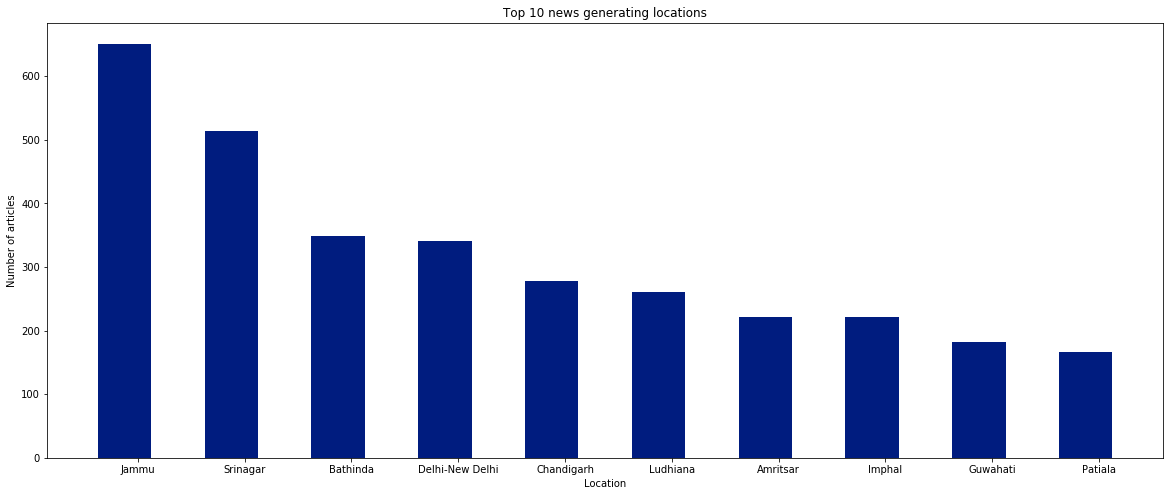

In [250]:
counter = Counter(df.location)
counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:10]
counter = np.array(counter)

places, counts = counter[:, 0].tolist(), counter[:, 1].astype(np.float32)
indices = np.arange(len(counts))
width = 1

plt.xlabel("Location")
plt.ylabel("Number of articles")
plt.interactive(True)

plt.xticks(indices + 0.125, places)
plt.title("Top 10 news generating locations")
_ = plt.bar(indices, counts, 0.5)

In [251]:
df = df[df['location'] == "Chennai"]
df['event_date'] = pd.to_datetime(df['event_date'])
df.sort_values(by=['timestamp'], inplace=True)

In [252]:
dates = pd.date_range(start=df.iloc[0]['event_date'], end=df.iloc[-1]['event_date'])
num_events = np.zeros(len(dates))

i = 0
for date in dates:
    num_events[i] += len(df[df['event_date'] == date])
    i += 1

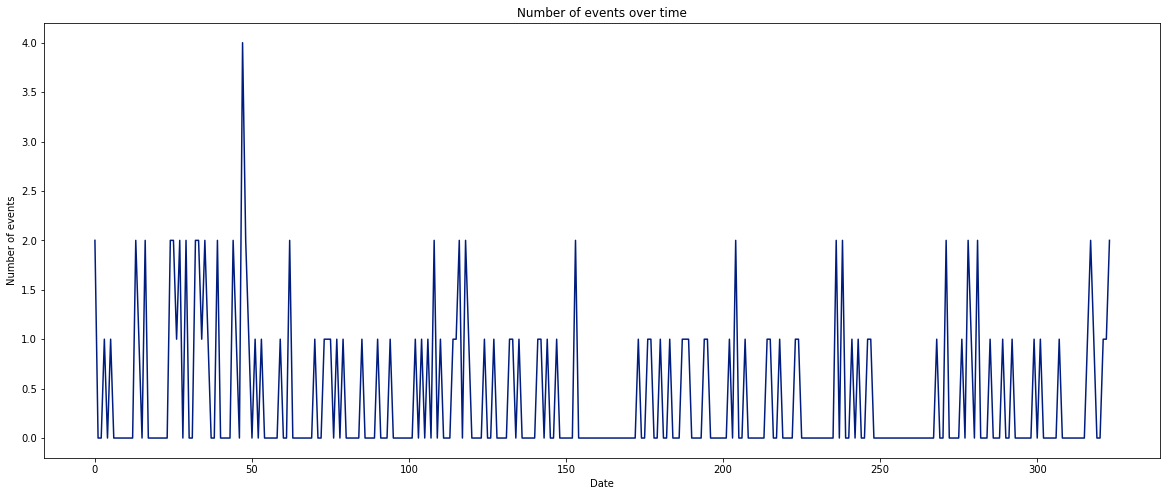

In [253]:
plt.title("Number of events over time")
plt.xlabel("Date")
plt.ylabel("Number of events")
_ = plt.plot(num_events)

In [254]:
news_articles = df.notes

In [255]:
def get_glove_dict():
    """
    Inputs - None
    
    Returns - Dict below
    
    Create a dict with word as key and word vector as value
    """
    d = {}
    f = open("../../glove_vectors/glove.6B.100d.txt", 'r')
    for row in f:
        row = row.replace('\n', '').split(" ")
        word = row[0]
        vector = np.array([float(x) for x in row[1:]])
        d[word] = vector
    f.close()
    return d

def generate_labels(num_events, num_days=2, days_window=2):
    """
    Inputs - 
        num_events - as generated as above 
        num_days - the number of days to after which we 
                   look for the occurence of an event.
                   Basically, the future
        day_window - If an event occurs in a window of days
                     after num_days
    
    Returns - Returns labels generated as below
    
    Generate labels by using the future events, basically
    look-ahead to create labels. If an event occurs from 
    i to i + num_days, then label is 1.0 else 0.0
    """
    n = len(num_events)
    labels = np.zeros(n - num_days - days_window)
    for i in range(n - num_days - days_window):
        labels[i] = 1.0 if sum(num_events[i + num_days: i + num_days + days_window] > 0) else 0.0
    return labels
    

In [118]:
vector = get_glove_dict()

In [256]:
labels = generate_labels(num_events)

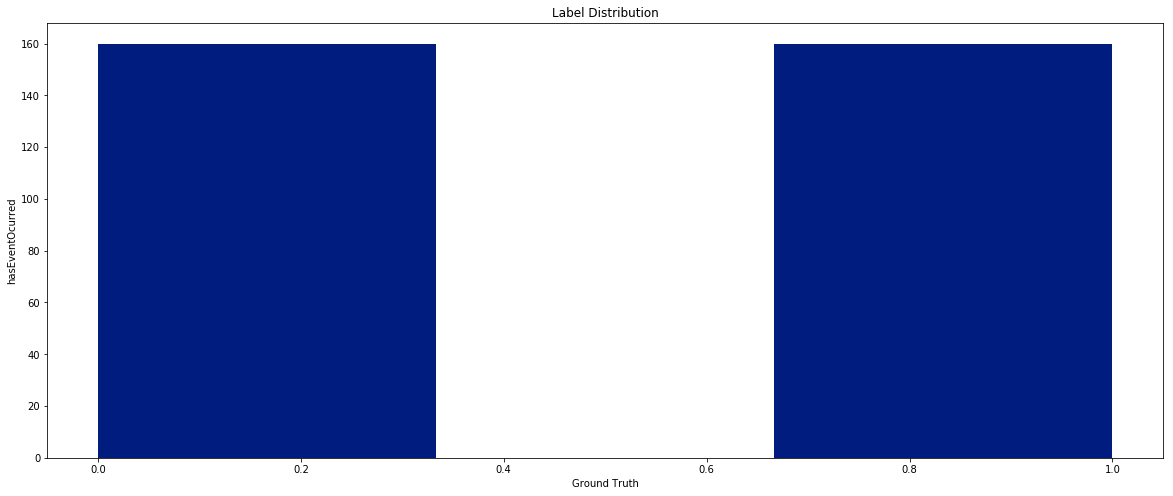

In [257]:
plt.title('Label Distribution')
plt.xlabel('Ground Truth')
plt.ylabel('hasEventOcurred')
_ = plt.hist(labels, bins=3, range=(0, 1))

In [258]:
# TODO - Arrange news articles for word2vec
# TODO - Run prelim model

In [259]:
# Tokenizer
nlp = spacy.load('en_core_web_sm')

# Generate sentence vectors
sentence_vectors = []
regexp = r'/[.,\/#!$%\^&\*;:{}=\-_`~()]/g'
num_sentences = len(news_articles)

for i, sentence in enumerate(news_articles):
    if i % 100 == 0:
        print (i, " / ", num_sentences, "done!")
    tokens = [t.text.lower() for t in nlp(sentence)]
    temp = []
    for token in tokens:
        vec = vector.get(token)
        if vec is None:
            vec = vector['unk']
        temp.append(vec)
    sentence_vectors.append(temp)
            

0  /  137 done!
100  /  137 done!


In [260]:
# For the sentence vector, currently, simply just use average of all words vectors
for i, vecs in enumerate(sentence_vectors):
    sentence_vectors[i] = np.mean(vecs, axis=0)

In [261]:
sentence_vectors = np.array(sentence_vectors)
print("Sentence vector shape -", sentence_vectors.shape)

Sentence vector shape - (137, 100)


In [262]:
df.index = np.arange(len(df))
df.head(5)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,actor1,assoc_actor_1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,1778518,356,IND27773,27773.0,2018-03-07,2018,1,Violence against civilians,DVK: Dravidar Viduthalai Kazhagam,NaN,...,Chennai,13.0878,80.2784,1,HIndustan Times,National,"On March 7, in Chennai (Chennai, TN), upper-ca...",0,1536936387,IND
1,1788097,356,IND27315,27315.0,2018-02-21,2018,1,Violence against civilians,Rioters (India),Students (India),...,Chennai,13.0878,80.2784,1,The Hindu,National,"On February 21, in Chennai (Chennai, TN), seve...",0,1536936396,IND
2,1795842,356,IND32806,32806.0,2018-06-30,2018,1,Violence against civilians,Vigilante Militia (India),NaN,...,Chennai,13.0878,80.2784,1,The Times of India (TOI),National,"On June 30, two men from the Metro Rail work w...",0,1536936403,IND
3,1795415,356,IND35456,35456.0,2018-08-27,2018,1,Violence against civilians,Unidentified Armed Group (India),NaN,...,Chennai,13.0878,80.2784,1,The Times of India (TOI),National,"On 27 August, a woman set an imam on fire at h...",1,1536936403,IND
4,1879423,356,IND37053,37053.0,2018-09-18,2018,1,Riots/Protests,Protesters (India),Hindu Group (India),...,Chennai,13.0878,80.2784,1,New Indian Express,National,"On September 18, in Chennai city (Chennai, TN)...",0,1538772218,IND


In [263]:
vec_date = []
for date in dates:
    temp_df = df[df['event_date'] == date]
    if len(temp_df) == 0:
        vec_date.append(np.zeros(100))

    else:
        indices = list(temp_df.index)
        vec_date_temp = np.mean(sentence_vectors[indices].reshape(-1, 100), axis=0)
        vec_date.append(vec_date_temp)
    

In [264]:
num_days, days_window = 2, 2
n = len(dates)

In [265]:
x, y = [], []
for i in range(history, n - num_days - days_window):
    x.append(vec_date[i - history: i])
    y.append(labels[i])

In [266]:
x, y = np.array(x), np.array(y)

In [267]:
print(x.shape, y.shape)

(315, 5, 100) (315,)


In [273]:
# Define model
import keras.layers as L
import keras.losses as losses
import keras.models as M
import keras.optimizers as opt
from keras.utils import to_categorical

In [286]:
model = M.Sequential()
model.add(L.LSTM(50, input_shape=(5, 100), return_sequences=True))
model.add(L.LSTM(10))
model.add(L.Dense(2))
model.add(L.Activation('softmax'))
opzr = opt.RMSprop(3e-5)
model.compile('rmsprop', loss=losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36_input (InputLayer)   (None, 5, 100)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 5, 50)             30200     
_________________________________________________________________
lstm_37 (LSTM)               (None, 10)                2440      
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 22        
_________________________________________________________________
activation_17 (Activation)   (None, 2)                 0         
Total params: 32,662
Trainable params: 32,662
Non-trainable params: 0
_________________________________________________________________


In [287]:
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2)

In [288]:
print('Train shape -', xtrain.shape)
print('Test shape -', xtest.shape)

Train shape - (252, 5, 100)
Test shape - (63, 5, 100)


In [289]:
ytrain, ytest = to_categorical(ytrain), to_categorical(ytest)
model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=200)

Train on 252 samples, validate on 63 samples
Epoch 1/200
252/252 [==============================] - 2s 9ms/step - loss: 0.7015 - acc: 0.5000 - val_loss: 0.6921 - val_acc: 0.6032
Epoch 2/200
252/252 [==============================] - 0s 322us/step - loss: 0.6926 - acc: 0.5238 - val_loss: 0.6968 - val_acc: 0.4286
Epoch 3/200
252/252 [==============================] - 0s 389us/step - loss: 0.6912 - acc: 0.5357 - val_loss: 0.6912 - val_acc: 0.5556
Epoch 4/200
252/252 [==============================] - 0s 363us/step - loss: 0.6904 - acc: 0.5278 - val_loss: 0.6929 - val_acc: 0.5079
Epoch 5/200
252/252 [==============================] - 0s 368us/step - loss: 0.6897 - acc: 0.5397 - val_loss: 0.6893 - val_acc: 0.6190
Epoch 6/200
252/252 [==============================] - 0s 355us/step - loss: 0.6907 - acc: 0.5714 - val_loss: 0.6959 - val_acc: 0.4286
Epoch 7/200
252/252 [==============================] - 0s 371us/step - loss: 0.6918 - acc: 0.5000 - val_loss: 0.6952 - val_acc: 0.4127
Epoch 8/200


Epoch 61/200
252/252 [==============================] - 0s 481us/step - loss: 0.6167 - acc: 0.6429 - val_loss: 0.6752 - val_acc: 0.5238
Epoch 62/200
252/252 [==============================] - 0s 413us/step - loss: 0.5895 - acc: 0.6349 - val_loss: 0.6650 - val_acc: 0.5873
Epoch 63/200
252/252 [==============================] - 0s 400us/step - loss: 0.5936 - acc: 0.6270 - val_loss: 0.6892 - val_acc: 0.5556
Epoch 64/200
252/252 [==============================] - 0s 362us/step - loss: 0.5632 - acc: 0.6667 - val_loss: 0.7109 - val_acc: 0.5397
Epoch 65/200
252/252 [==============================] - 0s 401us/step - loss: 0.5712 - acc: 0.6508 - val_loss: 0.7110 - val_acc: 0.5397
Epoch 66/200
252/252 [==============================] - 0s 404us/step - loss: 0.5892 - acc: 0.6905 - val_loss: 0.6710 - val_acc: 0.5714
Epoch 67/200
252/252 [==============================] - 0s 394us/step - loss: 0.6032 - acc: 0.6389 - val_loss: 0.7609 - val_acc: 0.4921
Epoch 68/200
252/252 [==========================

252/252 [==============================] - 0s 413us/step - loss: 0.4815 - acc: 0.7262 - val_loss: 0.8541 - val_acc: 0.5714
Epoch 122/200
252/252 [==============================] - 0s 398us/step - loss: 0.4668 - acc: 0.7460 - val_loss: 0.7975 - val_acc: 0.6032
Epoch 123/200
252/252 [==============================] - 0s 336us/step - loss: 0.4738 - acc: 0.7341 - val_loss: 0.7731 - val_acc: 0.6190
Epoch 124/200
252/252 [==============================] - 0s 339us/step - loss: 0.4469 - acc: 0.7579 - val_loss: 0.8017 - val_acc: 0.5714
Epoch 125/200
252/252 [==============================] - 0s 334us/step - loss: 0.5221 - acc: 0.6905 - val_loss: 0.9690 - val_acc: 0.5238
Epoch 126/200
252/252 [==============================] - 0s 432us/step - loss: 0.4368 - acc: 0.7540 - val_loss: 0.8646 - val_acc: 0.5556
Epoch 127/200
252/252 [==============================] - 0s 412us/step - loss: 0.4569 - acc: 0.7579 - val_loss: 0.7777 - val_acc: 0.5873
Epoch 128/200
252/252 [==============================] 

Epoch 181/200
252/252 [==============================] - 0s 411us/step - loss: 0.3688 - acc: 0.7937 - val_loss: 1.0413 - val_acc: 0.5238
Epoch 182/200
252/252 [==============================] - 0s 366us/step - loss: 0.4019 - acc: 0.7857 - val_loss: 0.9285 - val_acc: 0.6190
Epoch 183/200
252/252 [==============================] - 0s 376us/step - loss: 0.3651 - acc: 0.7937 - val_loss: 1.0528 - val_acc: 0.6190
Epoch 184/200
252/252 [==============================] - 0s 390us/step - loss: 0.4171 - acc: 0.7540 - val_loss: 0.8432 - val_acc: 0.6349
Epoch 185/200
252/252 [==============================] - 0s 419us/step - loss: 0.3826 - acc: 0.7857 - val_loss: 0.8966 - val_acc: 0.6032
Epoch 186/200
252/252 [==============================] - 0s 410us/step - loss: 0.3499 - acc: 0.8135 - val_loss: 1.0647 - val_acc: 0.5873
Epoch 187/200
252/252 [==============================] - 0s 440us/step - loss: 0.4505 - acc: 0.7540 - val_loss: 0.9563 - val_acc: 0.6190
Epoch 188/200
252/252 [==================